# Two Quantum Particles in a Harmonic Oscillator
by Jose Javier Fernández González

## Setting
Consider a system composed of 2 particles interacting via a repulsive delta-pseudopotential in 1D geometry. Ground-state properties in this system can be obtained using Monte Carlo methods. The delta-interaction potential results in a boundary condition on the two-body Jastrow term:

$$
f_2(r_{ij}) = r_{ij} - a_s
$$

The one-body term can be taken in the shape of a Gaussian

$$
f_1(r) = \exp(-\alpha r^2)
$$

where $\alpha$ is a variational parameter.

Calculate energy and correlation functions (radial density profile and pair correlation function).

Compare the variational energy with the exact analytical solution.

**Reference:** T. Busch, B.-G. Englert, K. Rzążewski, and M. Wilkens, *"Two Cold Atoms in a Harmonic Trap,"* Found. Phys. **28**, 549 (1998).


In [1]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import mpmath as mp

## Model

We consider a system of two particles of mass $m$ confined in a one-dimensional harmonic oscillator and interacting via a repulsive contact (delta) interaction.

### Hamiltonian

The Hamiltonian of the system is

$$
\hat{H} = -\frac{\hbar^2}{2m}\left(\frac{\partial^2}{\partial x_1^2} + \frac{\partial^2}{\partial x_2^2}\right) + \frac{1}{2} m \omega^2 (x_1^2 + x_2^2) + g\,\delta(|x_1 - x_2|),
$$

where

- $x_1, x_2$ are the particle coordinates,
- $\frac{1}{2} m \omega^2 x_i^2$ is the harmonic trapping potential,
- $g\,\delta(|x_1 - x_2|)$ describes the repulsive contact interaction.

We work in dimensionless harmonic oscillator units:

- energies in units of $\hbar \omega$,
- lengths in units of the oscillator length $r_0$ such that

$$
\frac{\hbar^2}{m r_0^2} = m \omega^2 r_0^2 = \hbar \omega.
$$

In these units, the Hamiltonian becomes

$$ 
\hat{H} = -\frac{1}{2}\left(\frac{\partial^2}{\partial x_1^2} + \frac{\partial^2}{\partial x_2^2}\right) + \frac{1}{2}(x_1^2 + x_2^2) + g\,\delta(|x_1 - x_2|).
$$

The phase space of the system is

$$
R = \{x_1, x_2\}.
$$

---

### Trial Wave Function (Jastrow Form)

We use a Jastrow pair-product trial wave function

$$
\psi_T(x_1, x_2) =
\prod_{i=1}^{2} f_1(x_i)\; f_2(|x_1 - x_2|),
$$

which includes:

#### One-body term (external confinement)

A Gaussian form accounting for the harmonic trap:

$$
f_1(x) = \exp(-\alpha x^2),
$$

where $\alpha$ is a variational parameter.

#### Two-body correlation term (contact interaction)

The delta interaction imposes a boundary condition on the pair function:

$$
f_2(r_{12}) = r_{12} - a_s,
$$

where

- $r_{12} = |x_1 - x_2|$,
- $a_s$ is the scattering length.

---

### Variational Monte Carlo Objective

The ground-state energy is estimated using the variational principle:

$$
E_{\mathrm{VMC}} = \frac{\int \psi_T^*(R)\hat{H}\psi_T(R)\,dR}{\int |\psi_T(R)|^2 dR} =\langle E_L(R) \rangle,
$$

where the local energy is

$$
E_L(R) = \frac{\hat{H}\psi_T(R)}{\psi_T(R)}.
$$

The variational parameter $\alpha$ is optimized to minimize the energy. From the Monte Carlo sampling one also computes:

- the radial density profile,
- the pair correlation function,
- the variational ground-state energy.

The results are compared with the exact analytical solution for two particles in a harmonic trap (Busch et al., 1998).


In [2]:
def local_energy_estimators(x1, x2, alpha, a_s, eps=1e-12):
    """
    Local energy for two particles in a 1D harmonic trap using the trial wave function:

        psi_T(x1,x2) = exp[-alpha*(x1^2+x2^2)] * (|x1-x2| - a_s)

    The contact interaction is enforced through the boundary condition
    in the wave function, so there is no explicit delta potential term.

    Returns
    -------
    energy   : local energy using Laplacian estimator
    """

    # harmonic trap potential (dimensionless units)
    V = 0.5 * (x1**2 + x2**2)

    # relative coordinate
    s = x1 - x2
    r = np.abs(s)
    sign_s = np.sign(s)

    # avoid division by zero near the node r = a_s
    u = r - a_s
    denom = np.sign(u) * np.maximum(np.abs(u), eps)


    # first derivatives of log(psi)
    d1 = -2.0 * alpha * x1 + sign_s / denom
    d2 = -2.0 * alpha * x2 - sign_s / denom

    # second derivatives of log(psi)
    # (ignoring delta-like contribution at s=0)
    dd1 = -2.0 * alpha - 1.0 / (denom**2)
    dd2 = -2.0 * alpha - 1.0 / (denom**2)

    # Laplacian estimator: second derivative psi / psi
    lap_over_psi = (dd1 + d1**2) + (dd2 + d2**2)
    energy = V - 0.5 * lap_over_psi

    return energy


## Helper and Simulation Functions

In [3]:
# Helper functions (two particles)

def gen_intial_config():
    return np.random.randn(2)

def move_points(x, delta=1.0, move_one=True):
    """
    Propose a new configuration from x = [x1, x2].

    If move_one is True, move only one randomly chosen particle each step.
    Otherwise, move both particles.
    """
    x_new = np.array(x, dtype=float, copy=True)

    if move_one:
        i = np.random.randint(0, 2)
        x_new[i] = x_new[i] + (2.0 * np.random.random() - 1.0) * delta
    else:
        x_new = x_new + (2.0 * np.random.random(size=2) - 1.0) * delta

    return x_new

def log_psi(x, alpha, a_s):
    """
    log psi_T(x1,x2) = -alpha*(x1^2 + x2^2) + log(|x1-x2| - a_s)
    """
    x1, x2 = x[0], x[1]
    r12 = np.abs(x1 - x2)
    return -alpha * (x1**2 + x2**2) + np.log(r12 - a_s)

def log_prob(x, alpha, a_s, eps=1e-12):
    x1, x2 = x
    r12 = abs(x1 - x2)          # scalar
    u = r12 - a_s
    u_safe = np.sign(u) * np.maximum(np.abs(u), eps)
    return -2*alpha*(x1*x1 + x2*x2) + 2*np.log(np.abs(u_safe))


def metropolis_step(x_old, x_new, alpha, a_s, eps=1e-12):
    """
    Metropolis accept/reject using p(x)=|psi|^2.
    Accept with prob min(1, exp(logp_new - logp_old)).
    Returns (x_next, accepted_flag).
    """
    logw = log_prob(x_new, alpha, a_s, eps=eps) - log_prob(x_old, alpha, a_s, eps=eps)

    if logw >= 0.0:
        return x_new, 1
    else:
        if np.random.random() < np.exp(logw):
            return x_new, 1
        return x_old, 0


In [4]:
def run_sim(
    n_steps=500_000,
    n_burn=20_000,
    thin=10,
    delta=1.0,
    move_one=True,
    alpha=0.5,
    a_s=-0.5,
    nbins_r=100,
    rmax=6.0,
    nbins_pair=100,
    pair_rmax=6.0,
):
    """
    Variational Monte Carlo for two particles in 1D harmonic trap
    Outputs:
      - mean energy and error
      - radial density profile n(x) built from samples of x1 and x2
      - pair correlation g(r) built from r = |x1-x2|
      - acceptance ratio
    """

    # histograms
    # density n(x): use symmetry, histogram of x in [-rmax, rmax]
    x_edges = np.linspace(-rmax, rmax, nbins_r + 1)
    x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
    hist_x = np.zeros(nbins_r, dtype=float)

    # pair correlation g(r): histogram of r in [0, pair_rmax]
    r_edges = np.linspace(0.0, pair_rmax, nbins_pair + 1)
    r_centers = 0.5 * (r_edges[:-1] + r_edges[1:])
    hist_r = np.zeros(nbins_pair, dtype=float)

    # accumulators for energy
    energy_sum = 0.0
    energy2_sum = 0.0
    n_meas = 0

    # initialize
    x = gen_intial_config()
    acc = 0

    for step in range(n_steps):
        # propose and accept/reject
        x_prop = move_points(x, delta=delta, move_one=move_one)
        x, accepted = metropolis_step(x, x_prop, alpha=alpha, a_s=a_s)
        acc += accepted

        # burn-in and thinning
        if step < n_burn:
            continue
        if ((step - n_burn) % thin) != 0:
            continue

        # measure observables
        x1, x2 = x[0], x[1]

        # energies
        energy = local_energy_estimators(x1, x2, alpha=alpha, a_s=a_s)
        energy_sum += energy
        energy2_sum += energy * energy
        
        # density profile: count both particles
        ix1 = np.searchsorted(x_edges, x1, side="right") - 1
        ix2 = np.searchsorted(x_edges, x2, side="right") - 1
        if 0 <= ix1 < nbins_r:
            hist_x[ix1] += 1.0
        if 0 <= ix2 < nbins_r:
            hist_x[ix2] += 1.0

        # pair correlation: r = |x1-x2|
        r12 = np.abs(x1 - x2)
        ir = np.searchsorted(r_edges, r12, side="right") - 1
        if 0 <= ir < nbins_pair:
            hist_r[ir] += 1.0

        n_meas += 1

    # acceptance
    acc_ratio = acc / float(n_steps)

    # energies + simple standard error with thinning as "uncorrelated" proxy
    energy_mean = energy_sum / n_meas
    energy_var = energy2_sum / n_meas - energy_mean**2
    energy_err = np.sqrt(max(energy_var, 0.0) / n_meas)

    # normalize density histogram to probability density
    # hist_x counts 2 particles per measurement
    dx = x_edges[1] - x_edges[0]
    density = hist_x / (np.sum(hist_x) * dx) if np.sum(hist_x) > 0 else hist_x.copy()

    # normalize pair histogram to probability density in r
    dr = r_edges[1] - r_edges[0]
    pair_pdf = hist_r / (np.sum(hist_r) * dr) if np.sum(hist_r) > 0 else hist_r.copy()

    results = {
        "energy_mean": energy_mean,
        "energy_err": energy_err,
        "acceptance": acc_ratio,
        "n_meas": n_meas,
        "x_centers": x_centers,
        "density": density,
        "r_centers": r_centers,
        "pair_pdf": pair_pdf,
        "params": {
            "n_steps": n_steps,
            "n_burn": n_burn,
            "thin": thin,
            "delta": delta,
            "move_one": move_one,
            "alpha": alpha,
            "a_s": a_s,
        },
    }
    return results

In [5]:
# Scan alpha, find optimum, and return all results
def scan_alpha(
    alphas,
    n_steps=500_000,
    n_burn=20_000,
    thin=10,
    delta=1.0,
    move_one=True,
    a_s=-1.5,
    nbins_r=100,
    rmax=6.0,
    nbins_pair=100,
    pair_rmax=6.0
):
    rows = []
    best_results = None
    best_energy = np.inf

    for alpha in alphas:
        results = run_sim(
            n_steps=n_steps,
            n_burn=n_burn,
            thin=thin,
            delta=delta,
            move_one=move_one,
            alpha=alpha,
            a_s=a_s,
            nbins_r=nbins_r,
            rmax=rmax,
            nbins_pair=nbins_pair,
            pair_rmax=pair_rmax,
        )

        # record a compact row for plotting/comparison
        row = {
            "alpha": alpha,
            "energy_mean": results["energy_mean"],
            "energy_err": results["energy_err"],
            "acceptance": results["acceptance"],
            "n_meas": results["n_meas"],
        }
        rows.append(row)

        # choose best
        E = row["energy_mean"]
        if E < best_energy:
            best_energy = E
            best_results = results  # keep full density/pair info for the best alpha

    return rows, best_results


def rows_to_arrays_alpha(rows):
    a   = np.array([r["alpha"] for r in rows])
    E   = np.array([r["energy_mean"] for r in rows])
    Ee  = np.array([r["energy_err"] for r in rows])
    acc = np.array([r["acceptance"] for r in rows])
    return a, E, Ee, acc


## Simulation Results

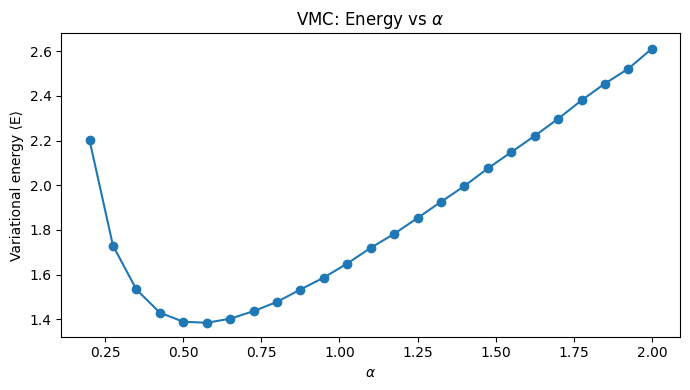

In [12]:
# Optimizing over alpha
alphas = np.linspace(0.2, 2.0, 25)
n_steps = 750_000

rows, best = scan_alpha(
    alphas,
    n_steps=n_steps
)

a, E, Ee, acc = rows_to_arrays_alpha(rows)

# plt.figure(figsize=(7,4), dpi=200)
plt.figure(figsize=(7,4))
plt.errorbar(a, E, yerr=Ee, fmt='o-', capsize=3)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'Variational energy ⟨E⟩')
plt.title(r"VMC: Energy vs $\alpha$")
plt.tight_layout()
plt.show()


In [13]:
# Recalculate best alpha with more steps:
n_steps = 2_000_000
best_res = run_sim(
    alpha=0.5,
    # alpha=best["params"]["alpha"],
    n_steps=n_steps
    )

print("Best alpha (by energy_mean):", best_res["params"]["alpha"])
print("Energy:", best_res["energy_mean"], "+/-", best_res["energy_err"])
print("Acceptance:", best_res["acceptance"])

Best alpha (by energy_mean): 0.5
Energy: 1.682658906250667 +/- 0.0003298060077053772
Acceptance: 0.7124465


### Density profile

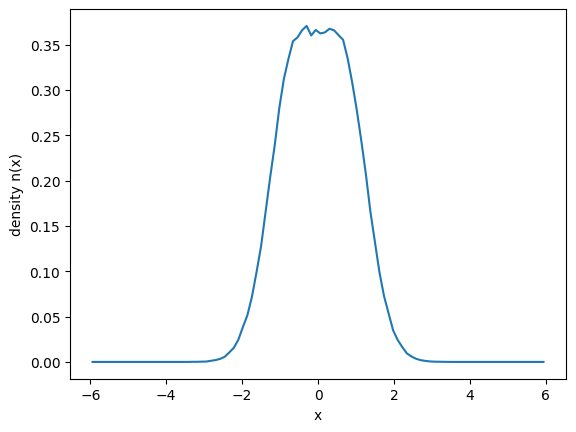

In [14]:
x = best_res["x_centers"]
n_x = best_res["density"]

# plt.figure(figsize=(7,5), dpi=200)
plt.figure()
plt.plot(x, n_x)
plt.xlabel("x")
plt.ylabel("density n(x)")
# plt.title("Radial density profile (1D)")
plt.show()


### Pair correlation

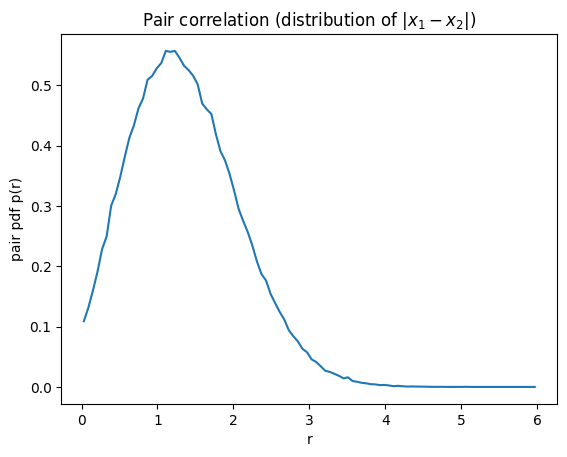

In [15]:
r = best_res["r_centers"]
p_r = best_res["pair_pdf"]

# plt.figure(figsize=(7,5), dpi=200)
plt.figure()
plt.plot(r, p_r)
plt.xlabel("r")
plt.ylabel("pair pdf p(r)")
plt.title(r"Pair correlation (distribution of |$x_1-x_2$|)")
plt.show()


## Comparison with analytical solution

In [16]:
def busch_eq16_lhs(E_rel):
    # Eq. (16) left-hand side: sqrt(2) * Gamma(-E/2 + 3/4) / Gamma(-E/2 + 1/4)
    return mp.sqrt(2) * mp.gamma(-E_rel/2 + mp.mpf("3")/4) / mp.gamma(-E_rel/2 + mp.mpf("1")/4)

def busch_eq16_residual(E_rel, a0):
    # Residual of Eq. (16): lhs - 1/a0
    return busch_eq16_lhs(E_rel) - (1.0 / a0)

def _safe_float(x):
    try:
        y = float(x)
        if np.isfinite(y):
            return y
        return np.nan
    except Exception:
        return np.nan

def exact_energy_two_particles_1d_from_busch(a0, E_min=-10.0, E_max=20.0, ngrid=20000):
    """
    Exact energies for 2 particles in 1D harmonic trap using Busch Eq. (16),
    applied to the 1D case as discussed in Sec. 3 of Busch et al.

    Returns the lowest even-parity solution for E_rel, then:
        E_total = 0.5 + E_rel
    """
    if a0 == 0:
        raise ValueError("a0 must be nonzero because Eq. (16) uses 1/a0.")

    # Avoid exact pole/zero locations:
    # zeros at E = 0.5 + 2n, poles at E = 1.5 + 2n
    def is_bad(E):
        # distance to nearest (0.5+2n) or (1.5+2n)
        # if too close, skip
        n0 = round((E - 0.5) / 2.0)
        n1 = round((E - 1.5) / 2.0)
        z = 0.5 + 2.0*n0
        p = 1.5 + 2.0*n1
        return (abs(E - z) < 1e-6) or (abs(E - p) < 1e-6)

    # Grid scan for a sign change of residual
    xs = np.linspace(E_min, E_max, ngrid)
    f_prev = None
    x_prev = None

    for x in xs:
        if is_bad(x):
            f_prev = None
            x_prev = None
            continue

        fx = _safe_float(busch_eq16_residual(mp.mpf(x), a0))
        if not np.isfinite(fx):
            f_prev = None
            x_prev = None
            continue

        if f_prev is not None and (f_prev * fx) < 0.0:
            # bracket found: [x_prev, x]
            a = mp.mpf(x_prev)
            b = mp.mpf(x)

            # bisection (very robust)
            fa = busch_eq16_residual(a, a0)
            fb = busch_eq16_residual(b, a0)

            root = mp.findroot(lambda E: busch_eq16_residual(E, a0), (a, b))
            E_rel = float(root)
            E_total = 0.5 + E_rel
            return E_total, E_rel

        f_prev = fx
        x_prev = x

    raise RuntimeError("No root found in the scan range.")


In [17]:
#Taking for the exact solution a0 = -a_s.
a0 = best_res["params"]["a_s"]

E_exact_total, E_exact_rel = exact_energy_two_particles_1d_from_busch(a0)

print("VMC energy (lap):", best_res["energy_mean"], "+/-", best_res["energy_err"])
print("Exact total energy:", E_exact_total)
print("Exact relative energy:", E_exact_rel)
print("VMC - exact:", best_res["energy_mean"] - E_exact_total)


VMC energy (lap): 1.682658906250667 +/- 0.0003298060077053772
Exact total energy: 1.6745040369392425
Exact relative energy: 1.1745040369392425
VMC - exact: 0.008154869311424395
